In [157]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import LeaveOneOut

In [158]:
#read data
with open('headers.txt') as f:
    lines = f.readlines()

for i in range(len(lines)):
    lines[i] = lines[i].split(" ")

headers = [lines[i][1] for i in range(len(lines))]

# preprocess data
raw = pd.read_csv('communities.data', names=headers)

# replace ? with np.nan
raw = raw.replace('?', np.nan)

#delete non-numeric columns, and target variable
to_delete = ['county', 'community', 'state', 'communityname', 'PolicOperBudg']

X = raw.drop(columns=to_delete)
y = raw.PolicOperBudg.astype(float).dropna()

X = X.dropna()
X = X.astype(float)

#combine X and y for later use
data = X.copy()
data['PolicOperBudg'] = y


In [159]:
#start with a regression over all the remaining variables
X = sm.add_constant(X)
regressor = sm.OLS(y, X)
model = regressor.fit()
model.summary()

#that's a lot of variables! Some of them are still dependent though. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          PolicOperBudg   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     91.81
Date:                Wed, 04 Mar 2020   Prob (F-statistic):          2.75e-129
Time:                        15:05:49   Log-Likelihood:                 824.70
No. Observations:                 319   AIC:                            -1401.
Df Residuals:                     195   BIC:                            -934.5
Df Model:                         123                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.7847      0.196     -3.996      0.000      -1.172      -0.397
fold                     -0.0002      0.001     -0.427      0.670      -0.001       0.001
population               -0.1990      0.363     -0.549      0.584      -0.914       0.516
householdsize            -0.0206      0.093     -0.221      0.825      -0.204       0.163
racepctblack             -0.0120      0.032     -0.380      0.705      -0.075       0.050
racePctWhite             -0.0397      0.045     -0.887      0.376      -0.128       0.049
racePctAsian              0.0035      0.022      0.163      0.870      -0.039       0.046
racePctHisp              -0.0199      0.032     -0.629      0.530      -0.082       0.042
agePct12t21               0.0490      0.092      0.531      0.596      -0.133       0.231
agePct12t29               0.2377      0.119      2.005      0.046       0.004       0.472
agePct16t24              -0.1515      0.138     -1.099      0.273      -0.423       0.120
agePct65up               -0.1022      0.091     -1.128      0.261      -0.281       0.077
numbUrban                 0.1366      0.368      0.371      0.711      -0.589       0.862
pctUrban                 -0.0269      0.026     -1.037      0.301      -0.078       0.024
medIncome                 0.0705      0.133      0.529      0.598      -0.193       0.334
pctWWage                 -0.0905      0.085     -1.061      0.290      -0.259       0.078
pctWFarmSelf              0.0072      0.023      0.310      0.757      -0.038       0.053
pctWInvInc                0.0082      0.046      0.178      0.859      -0.082       0.099
pctWSocSec                0.1162      0.089      1.310      0.192      -0.059       0.291
pctWPubAsst               0.0204      0.033      0.616      0.539      -0.045       0.086
pctWRetire               -0.0089      0.030     -0.295      0.769      -0.068       0.051
medFamInc                -0.0365      0.099     -0.367      0.714      -0.233       0.160
perCapInc                 0.0276      0.107      0.258      0.797      -0.184       0.239
whitePerCap              -0.0209      0.065     -0.322      0.748      -0.149       0.107
blackPerCap              -0.0151      0.035     -0.429      0.668      -0.084       0.054
indianPerCap              0.0082      0.019      0.443      0.658      -0.028       0.045
AsianPerCap              -0.0039      0.019     -0.202      0.840      -0.042       0.034
OtherPerCap               0.0053      0.020      0.267      0.790      -0.034       0.045
HispPerCap               -0.0021      0.023     -0.095      0.925      -0.047       0.043
NumUnderPov               0.0462      0.049      0.950      0.344      -0.050       0.142
PctPopUnderPov           -0.0296      0.057     -0.524      0.601      -0.141       0.082
PctLess9thGrade        

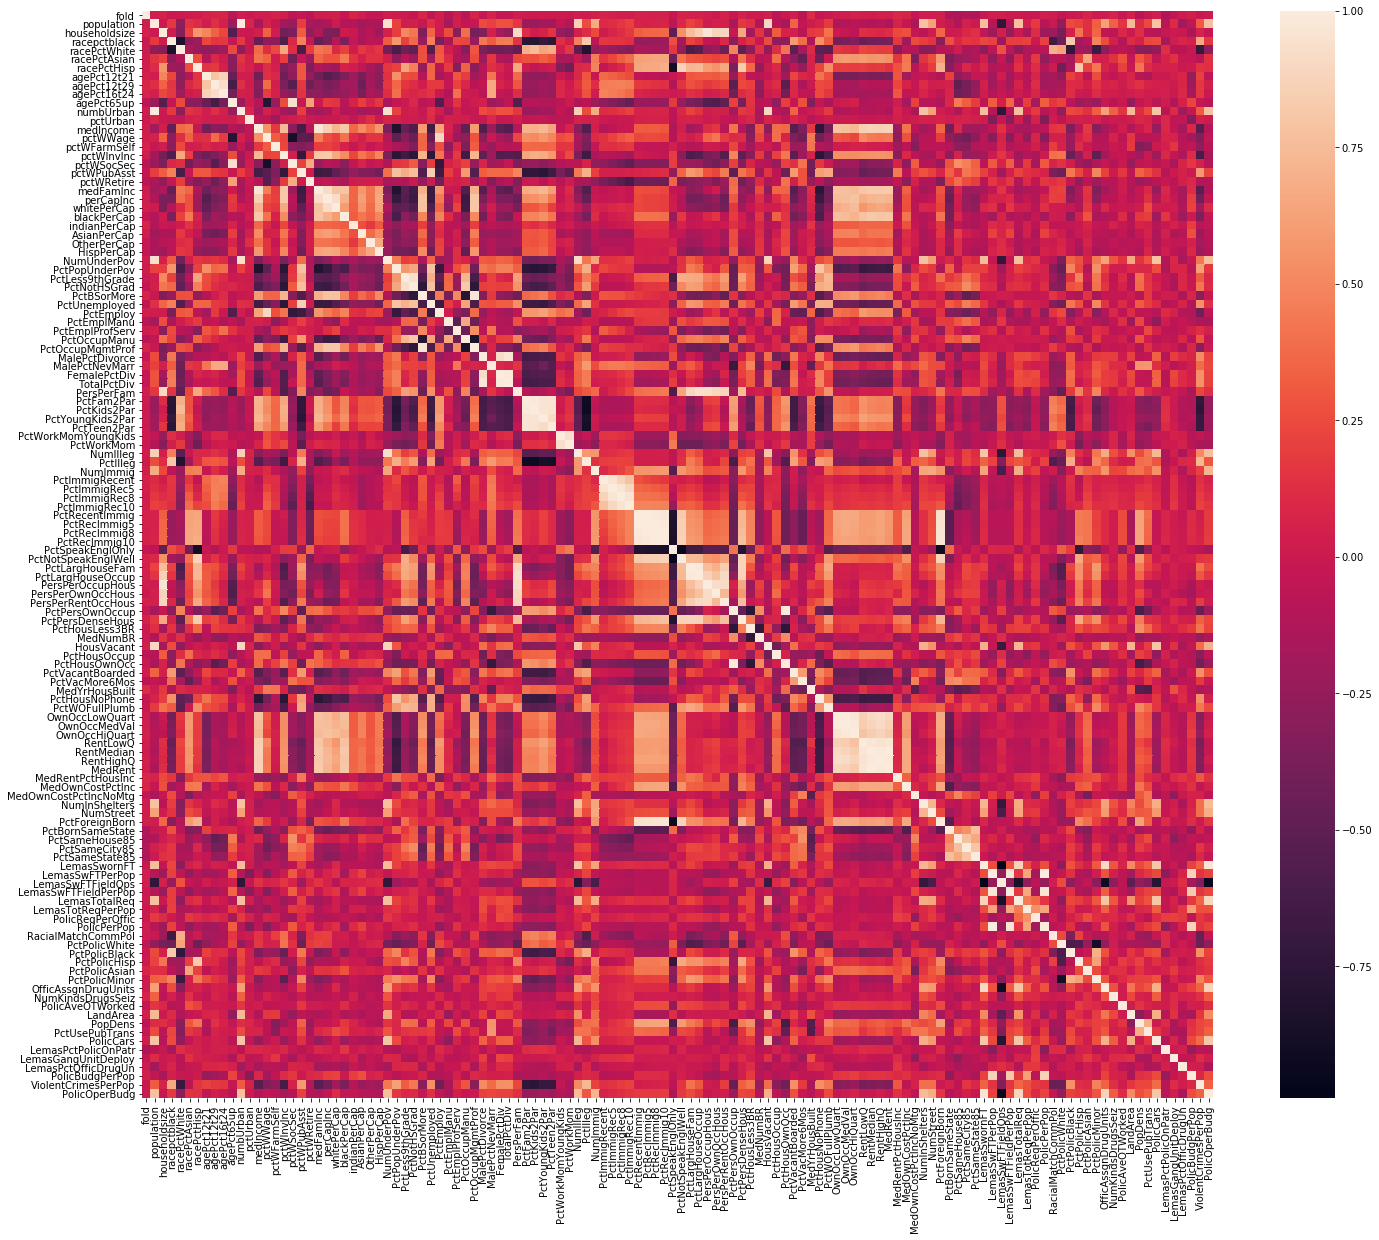

In [160]:
# Let's explore the correlations, both of the features to each other and to the target variable.
plt.figure(figsize=(24,20))
cor = data.corr()
g = sns.heatmap(cor, xticklabels=1, yticklabels=1)
g.figure.savefig("heatmap.png")

In [161]:
# This heatmap is massive! Let's simplify things by discarding all the variables
# that have a low correlation with the target variable
highly_correlated = cor[abs(cor.PolicOperBudg) > 0.5]

highly_correlated_features = data[highly_correlated.index]
X = X[highly_correlated.index.drop('PolicOperBudg')]

print("Features to keep:", X.columns)

Features to keep: Index(['population', 'numbUrban', 'NumUnderPov', 'NumIlleg', 'NumImmig',
       'HousVacant', 'NumInShelters', 'NumStreet', 'LemasSwornFT',
       'LemasSwFTFieldOps', 'LemasTotalReq', 'OfficAssgnDrugUnits', 'LandArea',
       'PolicCars'],
      dtype='object')


In [162]:
# All the features now have a high correlation with the target variable.

print(highly_correlated.PolicOperBudg)


population             0.778311
numbUrban              0.778152
NumUnderPov            0.760162
NumIlleg               0.766378
NumImmig               0.718067
HousVacant             0.692732
NumInShelters          0.744298
NumStreet              0.688507
LemasSwornFT           0.962132
LemasSwFTFieldOps     -0.940676
LemasTotalReq          0.890206
OfficAssgnDrugUnits    0.870884
LandArea               0.524821
PolicCars              0.802372
PolicOperBudg          1.000000
Name: PolicOperBudg, dtype: float64


In [163]:
#lets make a new regression
X = sm.add_constant(X)
regressor = sm.OLS(y, X)
model = regressor.fit()
model.summary()

#Many of the variables have insignificant P values. Let's remove them

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          PolicOperBudg   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     525.9
Date:                Wed, 04 Mar 2020   Prob (F-statistic):          1.35e-203
Time:                        15:05:53   Log-Likelihood:                 689.37
No. Observations:                 319   AIC:                            -1349.
Df Residuals:                     304   BIC:                            -1292.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.5873      0.096     -6.128      0.000      -0.776      -0.399
population             -0.2831      0.318     -0.890      0.374      -0.909       0.343
numbUrban               0.3206      0.321      0.998      0.319      -0.311       0.953
NumUnderPov            -0.0342      0.028     -1.234      0.218      -0.089       0.020
NumIlleg               -0.0529      0.023     -2.331      0.020      -0.098      -0.008
NumImmig                0.0767      0.016      4.825      0.000       0.045       0.108
HousVacant              0.0006      0.015      0.041      0.967      -0.029       0.031
NumInShelters           0.0293      0.015      1.986      0.048       0.000       0.058
NumStreet               0.0423      0.012      3.399      0.001       0.018       0.067
LemasSwornFT            1.3385      0.102     13.117      0.000       1.138       1.539
LemasSwFTFieldOps       0.5885      0.097      6.077      0.000       0.398       0.779
LemasTotalReq           0.1169      0.024      4.891      0.000       0.070       0.164
OfficAssgnDrugUnits    -0.0066      0.034     -0.195      0.846      -0.074       0.061
LandArea               -0.0053      0.013     -0.405      0.686      -0.031       0.020
PolicCars               0.0162      0.017      0.958      0.339      -0.017       0.049
==============================================================================
Omnibus:                      100.289   Durbin-Watson:                   2.064
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              915.362
Skew:                           1.006   Prob(JB):                    1.71e-199
Kurtosis:                      11.051   Cond. No.                         427.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [169]:
X = X.drop(columns=['const'])

#Backward Elimination
Rs = []
selected_features_BE = []
cols = list(X.columns)
pmax = 1
flag=False
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    Rs += [model.rsquared_adj]
    if(pmax<0.05 and flag==False):
        selected_features_BE = cols.copy()
        flag=True
    cols.remove(feature_with_p_max)

print("Selected Features:",selected_features_BE)


#based on towards data science: Feature Selection with sklearn and Pandas

Selected Features: ['NumIlleg', 'NumImmig', 'NumInShelters', 'NumStreet', 'LemasSwornFT', 'LemasSwFTFieldOps', 'LemasTotalReq']


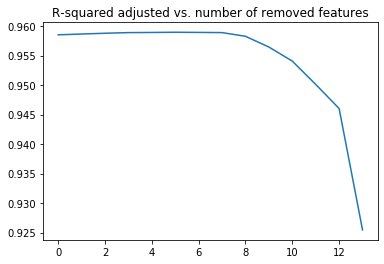

In [165]:
# When is our R^2 Adj maximized?
plt.plot(range(len(Rs)), Rs)
plt.title('R-squared adjusted vs. number of removed features')
plt.show()



In [166]:
# regression with only significant variables
X = sm.add_constant(X[selected_features_BE])
regressor = sm.OLS(y, X)
model = regressor.fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          PolicOperBudg   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     1061.
Date:                Wed, 04 Mar 2020   Prob (F-statistic):          7.64e-213
Time:                        15:05:53   Log-Likelihood:                 687.19
No. Observations:                 319   AIC:                            -1358.
Df Residuals:                     311   BIC:                            -1328.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.5846      0.092     -6.322      0.000      -0.767      -0.403
NumIlleg             -0.0622      0.014     -4.535      0.000      -0.089      -0.035
NumImmig              0.0761      0.013      5.739      0.000       0.050       0.102
NumInShelters         0.0338      0.014      2.400      0.017       0.006       0.062
NumStreet             0.0435      0.012      3.621      0.000       0.020       0.067
LemasSwornFT          1.3489      0.096     14.053      0.000       1.160       1.538
LemasSwFTFieldOps     0.5919      0.094      6.326      0.000       0.408       0.776
LemasTotalReq         0.1233      0.022      5.623      0.000       0.080       0.166
==============================================================================
Omnibus:                      105.133   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              882.192
Skew:                           1.101   Prob(JB):                    2.72e-192
Kurtosis:                      10.844   Cond. No.                         141.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

c:\users\drew\appdata\local\programs\python\python38\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


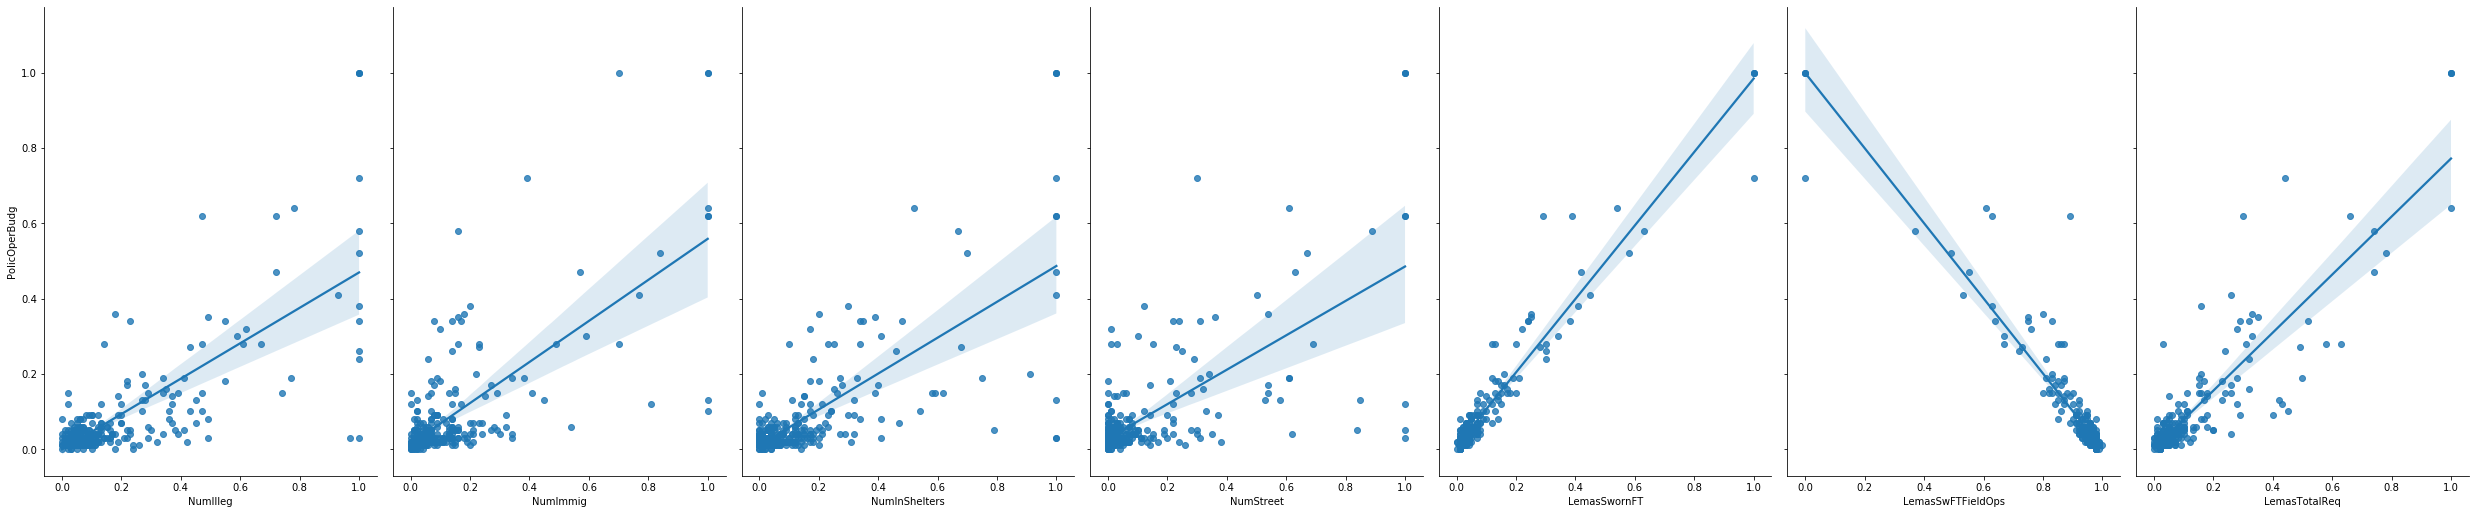

In [167]:
#check linearity assumptions
full_data = X.copy()
full_data['PolicOperBudg'] = y.copy()
 
# z_scores = stats.zscore(full_data)
# 
# abs_z_scores = np.abs(z_scores)
# filtered_entries = (abs_z_scores < 3).any(axis=1)
# new_df = full_data[filtered_entries]

sns.pairplot(full_data, x_vars=['NumIlleg', 'NumImmig', 'NumInShelters', 'NumStreet', 'LemasSwornFT', 'LemasSwFTFieldOps', 'LemasTotalReq']
, y_vars=['PolicOperBudg'], size=7, aspect=0.7, kind='reg')

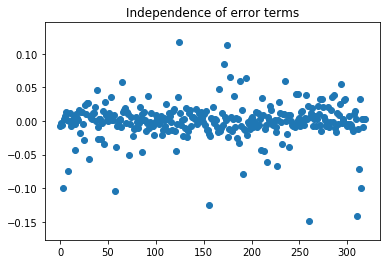

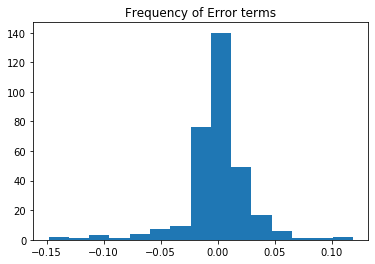

In [168]:
#check the error terms
errors = model.predict(X) - y

plt.scatter(range(len(errors)), errors)
plt.title('Independence of error terms')
plt.show()

#independent and homodesiastic!

plt.hist(errors, bins=15)

plt.title('Frequency of Error terms')
plt.show()
